In [1]:
import pandas as pd
import numpy as np
import glob

import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize import word_tokenize

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import roc_auc_score
from sklearn.metrics.pairwise import cosine_similarity

import matplotlib.pyplot as plt
import seaborn as sns

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
db = pd.read_csv('./sampleorig.csv')
db.describe()

,Unnamed: 0,id,age
count,10000.000000,1.000000e+04,10000.000000
mean,188146.672800,2.360750e+06,24.130900
std,108352.699739,1.283130e+06,7.651197
min,74.000000,8.173000e+03,13.000000
25%,94432.750000,1.103575e+06,17.000000
50%,188383.500000,2.581386e+06,24.000000
75%,282350.750000,3.542478e+06,27.000000
max,375944.000000,4.334776e+06,48.000000


In [4]:
db.topic.value_counts()

indUnk                     3658
Student                    2110
Technology                  665
Education                   499
Arts                        457
Communications-Media        320
Non-Profit                  228
Internet                    220
Engineering                 198
Law                         149
Publishing                  107
Government                  107
Consulting                  102
Science                      96
Marketing                    93
Fashion                      89
Accounting                   89
BusinessServices             61
Telecommunications           61
Advertising                  59
Sports-Recreation            56
Military                     55
Biotech                      55
Religion                     48
Chemicals                    46
Banking                      43
Transportation               41
Manufacturing                37
Museums-Libraries            37
LawEnforcement-Security      35
Agriculture                  25
Investme

In [6]:
db = db[['gender','text','id']]

dbm = db.groupby(['gender','id'])\
    .apply(lambda x: ' '.join(x.text))\
    .to_frame()\
    .rename(columns={0:'text'})
dbm.reset_index(inplace=True)
dbm.head()

,gender,id,text
0,female,28417,Perhaps so. But I hardly inferred ...
1,female,48923,Leigha is performing in a ur...
2,female,66895,It's been a while since anything ...
3,female,78196,Something went terribly wrong...
4,female,96600,Something that I have been thinki...


#### Analyzing the class balance

In [7]:
dbm.gender.value_counts()

female    1872
male      1840
Name: gender, dtype: int64

#### Feature engineering

In [9]:
dbm.text = dbm.text.str.strip()
dbm['clen'] = dbm.text.str.len()
dbm['numb'] = dbm.text.str.count(r'\d')/dbm['clen']
dbm['caps'] = dbm.text.str.count(r'[A-Z]')/dbm['clen']
dbm['wordlen'] = dbm.text.apply(lambda x: len(str(x).split()))
dbm['schar'] = (dbm.text.str.count(r'\W')-dbm.text.str.count(r'\W\S'))/dbm['clen']
dbm['unique_wlen_percent']=(dbm.text.apply(lambda x: len(set(str(x).split()))))/dbm['wordlen']
dbm['clen_wlen']=dbm['clen']/dbm['wordlen']
dbm.reset_index(inplace=True)
dbm.drop(['index'], axis=1, inplace=True)
dbm.head()

,gender,id,text,clen,numb,caps,wordlen,schar,unique_wlen_percent,clen_wlen
0,female,28417,Perhaps so. But I hardly inferred that every l...,4817,0.003322,0.022628,848,0.047955,0.587264,5.680425
1,female,48923,Leigha is performing in a urlLink one-woman s...,3489,0.000287,0.007165,613,0.050731,0.539967,5.691680
2,female,66895,It's been a while since anything new came up o...,451,0.004435,0.024390,84,0.035477,0.857143,5.369048
3,female,78196,Something went terribly wrong late last night....,25627,0.001327,0.048660,4636,0.068014,0.410699,5.527826
4,female,96600,Something that I have been thinking is that we...,1950,0.006154,0.019487,355,0.047692,0.577465,5.492958


### Analyzing the blog Sentiment - Using NLTK

In [11]:
import nltk
nltk.download('vader_lexicon')

#Sentiment analyzer
sentiment_val = dbm.text.apply(lambda x: SentimentIntensityAnalyzer().polarity_scores(x))

pol_values=[]
for i in sentiment_val:
    pol_val = list(i.values())
    pol_values.append(pol_val)

sent = pd.DataFrame(pol_values)
sent.rename(columns = {0:'neg',1:'neu',2:'pos',3:'compound'}, inplace=True)
sent.head()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


,neg,neu,pos,compound
0,0.103,0.747,0.150,0.9940
1,0.042,0.840,0.118,0.9958
2,0.000,0.909,0.091,0.7430
3,0.176,0.699,0.125,-0.9999
4,0.022,0.858,0.120,0.9742


In [12]:
dbm = pd.merge(dbm,sent,how='inner',left_index=True,right_index=True)
dbm_male = dbm.loc[dbm['gender']=='male'].copy()
dbm_female = dbm.loc[dbm['gender']=='female'].copy()

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


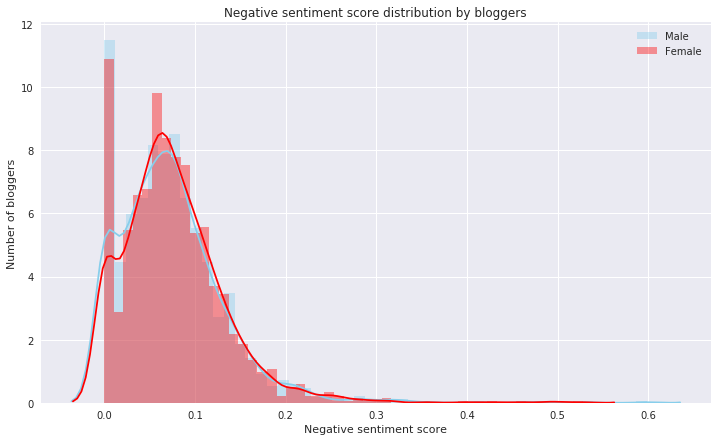

In [13]:
sns.set(style="darkgrid")
fig, ax = plt.subplots()
fig.set_size_inches(12,7)
sns.distplot( dbm_male.neg , color="skyblue", label="Male")
sns.distplot( dbm_female.neg , color="red", label="Female")
plt.title("Negative sentiment score distribution by bloggers")
plt.xlabel("Negative sentiment score")
plt.ylabel("Number of bloggers")
plt.legend()
plt.show()

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


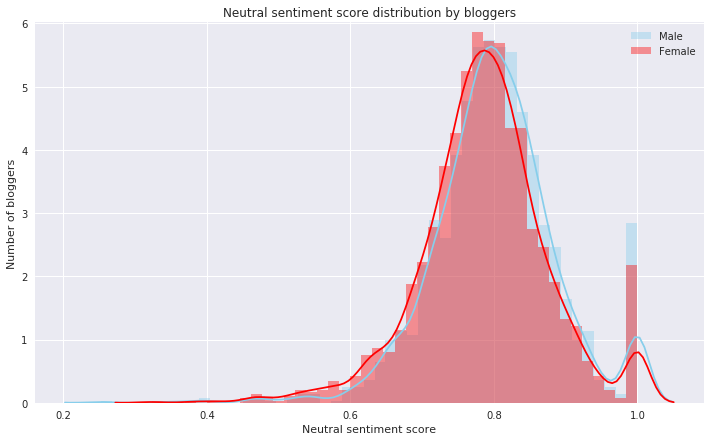

In [14]:
sns.set(style="darkgrid")
fig, ax = plt.subplots()
fig.set_size_inches(12,7)
sns.distplot( dbm_male.neu , color="skyblue", label="Male")
sns.distplot( dbm_female.neu , color="red", label="Female")

plt.title("Neutral sentiment score distribution by bloggers")
plt.xlabel("Neutral sentiment score")
plt.ylabel("Number of bloggers")
plt.legend()
plt.show()

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


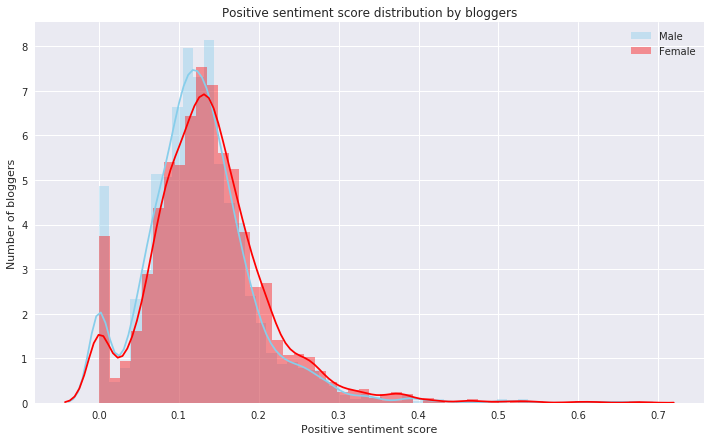

In [15]:
sns.set(style="darkgrid")
fig, ax = plt.subplots()
fig.set_size_inches(12,7)
sns.distplot( dbm_male.pos , color="skyblue", label="Male")
sns.distplot( dbm_female.pos , color="red", label="Female")

plt.title("Positive sentiment score distribution by bloggers")
plt.xlabel("Positive sentiment score")
plt.ylabel("Number of bloggers")
plt.legend()
plt.show()

#### Analyzing the sentiment scores, we can observe that they are not highly differentiated across genders

In [ ]:
#Cleaning
dbm.text = dbm.text.str.lower()
dbm.text = dbm.text.str.replace('[^a-zA-Z]'," ")
dbm.text = dbm.text.str.replace('urllink'," ")
dbm.text = dbm.text.str.replace('nbsp'," ")
dbm.text = dbm.text.str.replace(r'\n',' ')
dbm.text = dbm.text.str.replace(r'\s+',' ')
dbm.text = dbm.text.str.replace('([ ]{2,})',' ')
dbm = dbm[~dbm.text.str.match(r'^\s*$')]
dbm = dbm[dbm.text.apply(lambda x:len(x))>10]

In [17]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
labelencoder_X_1 = LabelEncoder()
dbm['gender_ohe'] = labelencoder_X_1.fit_transform(dbm.loc[:,'gender'])

In [ ]:
vect = TfidfVectorizer(max_df=0.5,min_df=0.005,lowercase=True,stop_words='english',norm='l1',ngram_range=(1,2),max_features=3000).fit(dbm.text)
tfidf = vect.transform(dbm.text)
cosine = cosine_similarity(tfidf)
cosine = pd.DataFrame(cosine)

### Interactive Visualization

#### Creating a function for finding gender of k-nearest neighbours based on Cosine Similarity

In [84]:
def similiarity_user(userid, k):
    rno = dbm[dbm.id==userid].index.values
    cosine_topk = pd.DataFrame({n: cosine.T[col].nlargest(k+1).index.tolist() for n, col in enumerate(cosine.T)}).T
    print("Gender of the user is : {}".format(dbm.loc[dbm.id==userid,'gender'][1]))
    for i in range(k):
        print("Gender of {}-nearest user is : {}".format(i+1,dbm.loc[cosine_topk.loc[rno][i+1],'gender'].values))

In [85]:
userid = 48923
k_nearest_neighbours = 5
similiarity_user(userid,k_nearest_neighbours)

Gender of the user is : female
Gender of 1-nearest user is : ['male']
Gender of 2-nearest user is : ['male']
Gender of 3-nearest user is : ['female']
Gender of 4-nearest user is : ['female']
Gender of 5-nearest user is : ['female']
